In [1]:
install.packages("nloptr")
install.packages("lme4")
install.packages("arm")
install.packages("dplyr")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/4.1/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/4.1/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/4.1/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/4.1/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/4.1/site-library’
(as ‘lib’ is unspecified)



In [1]:
# Import dependencies
library(arm)
library(dplyr)
library(ggplot2)

Loading required package: MASS

Loading required package: Matrix

Loading required package: lme4


arm (Version 1.12-2, built: 2021-10-15)


Working directory is /Users/av/Git/DTAmeta



Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Import data
Data <- read.csv("Data_m.csv")

In [37]:
### MAIN FUNCTION ###
# Data correction
Data_Correction = function(tp, fp, fn, tn) {
    k = length(tp)
    tp_c = tp
    fp_c = fp
    fn_c = fn
    tn_c = tn
    continuity = rep(0, k)
    for (i in 1: k) {
      if (tp[i] == 0|fp[i] == 0|fn[i] == 0|tn[i] == 0) continuity[i] = 1
      }
    for (i in 1: k) {
      if (continuity[i] == 1)  tp_c[i] = tp[i] + 0.5
      }
    for (i in 1: k) {
      if (continuity[i] == 1)  fp_c[i] = fp[i] + 0.5
      }
    for (i in 1: k) {
      if (continuity[i] == 1)  fn_c[i] = fn[i] + 0.5
      }
    for (i in 1: k) {
      if (continuity[i] == 1)  tn_c[i] = tn[i] + 0.5
      }

    ## Set global variables
    tp_c <<- tp_c
    fp_c <<- fp_c
    fn_c <<- fn_c
    tn_c <<- tn_c
    k <<- k
}

# Calculate ln(DOR) IVhet
IVhet_ln_DOR = function(tp, fp, fn, tn) {
    Data_Correction(tp, fp, fn, tn)
    dor = (tp_c * tn_c) / (fp_c * fn_c)
    ln_dor <- log(dor)
    se_dor = (1 / tp_c) + (1 / fp_c) + (1 / fn_c) + (1 / tn_c)
    w = 1 / se_dor
    ln_dor_ivhet = sum(w * ln_dor) / sum(w)

    ## Set global variables
    ln_dor <<- ln_dor
    se_dor <<- se_dor
    ln_dor_ivhet <<- ln_dor_ivhet
    w <<- w
}

# Split to logit(Sensitivity) IVhet and logit(Specificity) IVhet
SeSp = function(tp, fp, fn, tn) {
    IVhet_ln_DOR(tp, fp, fn, tn)
    centerlnDOR = ln_dor - ln_dor_ivhet
    logitSe <- lm(logit(tp_c / (tp_c + fn_c)) ~ centerlnDOR)
    logitSp <- lm(logit(tn_c / (tn_c + fp_c)) ~ centerlnDOR)
    Se_ivhet = invlogit(as.numeric(logitSe$coefficients[1]))
    Sp_ivhet = invlogit(as.numeric(logitSp$coefficients[1]))

    ## Set global variables
    logitSe <<- logitSe
    logitSp <<- logitSp
    Se_ivhet <<- Se_ivhet
    Sp_ivhet <<- Sp_ivhet
}

# Calculate variances, SD, and 95% CI of ln(DOR) IVhet,
# Se IVhet, and Sp IVhet
Dispersion = function(tp, fp, fn, tn) {
    SeSp(tp, fp, fn, tn)
    Q = sum(w * (ln_dor - ln_dor_ivhet)^2)
    df = k - 1
    Q_df = Q - df
    C = sum(w) - sum(w^2) / sum(w)
    tau2 = Q_df / C
    I2 <- (Q_df / Q) * 100
    bst = max(0,tau2)
    var_ln_dor = sum((w / sum(w))^2 * (se_dor + bst))
    sd_ln_dor = sqrt(var_ln_dor)
    low_ln_dor_ivhet = ln_dor_ivhet - 1.96 * sd_ln_dor
    up_ln_dor_ivhet = ln_dor_ivhet + 1.96 * sd_ln_dor
    se_ln_dor_ivhet = (up_ln_dor_ivhet - low_ln_dor_ivhet) / 3.92

    var_Se_ivhet = var_ln_dor * (0.5 - ((Se_ivhet * (1 - Se_ivhet)) -
                                      0.25) + ((Sp_ivhet * (1 - Sp_ivhet)) - 0.25))
    var_Sp_ivhet = var_ln_dor * (0.5 + ((Se_ivhet*(1 - Se_ivhet)) -
                                      0.25) - ((Sp_ivhet * (1 - Sp_ivhet)) - 0.25))
    sd_Se = sqrt(var_Se_ivhet)
    sd_Sp = sqrt(var_Sp_ivhet)

    low_logitSe_ivhet = as.numeric(logitSe$coefficients[1]) - 1.96 * sd_Se
    up_logitSe_ivhet = as.numeric(logitSe$coefficients[1]) + 1.96 * sd_Se
    low_Se_ivhet = invlogit(low_logitSe_ivhet)
    up_Se_ivhet = invlogit(up_logitSe_ivhet)
    low_logitSp_ivhet = as.numeric(logitSp$coefficients[1]) - 1.96 * sd_Sp
    up_logitSp_ivhet = as.numeric(logitSp$coefficients[1]) + 1.96 * sd_Sp
    low_Sp_ivhet = invlogit(low_logitSp_ivhet)
    up_Sp_ivhet = invlogit(up_logitSp_ivhet)

    ## Set global variables
    tau2 <<- tau2
    I2 <<- I2
    var_ln_dor <<- var_ln_dor
    sd_ln_dor <<- sd_ln_dor
    low_ln_dor_ivhet <<- low_ln_dor_ivhet
    up_ln_dor_ivhet <<- up_ln_dor_ivhet
    se_ln_dor_ivhet <<- se_ln_dor_ivhet

    ## Print
    print(paste("Sensitivity (95% CI): ", round(Se_ivhet,2),
              "(", round(low_Se_ivhet, 2), "; ", round(up_Se_ivhet, 2), ")"))
    print(paste("Specificity (95% CI): ", round(Sp_ivhet, 2),
              "(", round(low_Sp_ivhet, 2), "; ", round(up_Sp_ivhet, 2), ")"))
    print(paste("Q: ", round(Q, 2)))
    print(paste("Tau2: ", round(tau2, 2)))
    print(paste("I2 statistic: ", round(I2, 0), "%"))
}

# Calculate DOR IVhet and its 95% CI
IVhet_DOR = function(tp, fp, fn, tn) {
    Dispersion(tp, fp, fn, tn)
    dor_ivhet = exp(ln_dor_ivhet)
    dor_ivhet_low = exp(low_ln_dor_ivhet)
    dor_ivhet_up = exp(up_ln_dor_ivhet)

    ## Set global variables
    dor_ivhet <<- dor_ivhet
    dor_ivhet_low <<- dor_ivhet_low
    dor_ivhet_up <<- dor_ivhet_up

    ## Print
    print(paste("DOR (95% CI): ", round(dor_ivhet, 2),
              "(", round(dor_ivhet_low, 2), "; ", round(dor_ivhet_up, 2), ")"))
}

# Calculate AUC IVhet
AUC_IVhet = function(tp, fp, fn, tn) {
    IVhet_DOR(tp, fp, fn, tn)
    if (dor_ivhet >= 1) {
      AUC = invlogit(ln_dor_ivhet / 2)
  } else {
      AUC = 1 - invlogit(log(1 / dor_ivhet) / 2)
  }
    if (dor_ivhet >= 1) {
      low_AUC = invlogit(low_ln_dor_ivhet / 2)
  } else {
      low_AUC = 1 - invlogit(log(1 / dor_ivhet_low) / 2)
  }
    if (dor_ivhet >= 1) {
      up_AUC = invlogit(up_ln_dor_ivhet / 2)
  } else {
      up_AUC = 1 - invlogit(log(1/dor_ivhet_up) / 2)
  }

    ## Print
    print(paste("AUC (95% CI): ", round(AUC, 2), "(", round(low_AUC, 2),
              "; ", round(up_AUC, 2),")"))
}

# Calculate likelihood ratios IVhet
LR_IVhet = function(tp, fp, fn, tn) {
    AUC_IVhet(tp, fp, fn, tn)
    pLR = Se_ivhet / (1 - Sp_ivhet)
    ln_pLR = log(pLR)
    nLR = (1 - Se_ivhet) / Sp_ivhet
    ln_nLR = log(nLR)

    prop1 = abs(ln_pLR) / (abs(ln_pLR) + abs(ln_nLR))
    prop2 = abs(ln_nLR) / (abs(ln_pLR) + abs(ln_nLR))

    Se_plr = sqrt(prop1 * ln_dor_ivhet)

    if (dor_ivhet == 1) {
      Se_plr = sqrt(0.5 * ln_dor_ivhet)
  }
    pLR_low = exp(ln_pLR - 1.96 * Se_plr)
    pLR_up = exp(ln_pLR + 1.96 * Se_plr)

    Se_nlr = sqrt(prop2 * ln_dor_ivhet)
    if (dor_ivhet == 1) {
      Se_nlr = sqrt(0.5 * ln_dor_ivhet)
  }
    nLR_low = exp(ln_nLR - 1.96 * Se_nlr)
    nLR_up = exp(ln_nLR + 1.96 * Se_nlr)

    ## Print
    print(paste("Positive LR (95% CI): ", round(pLR, 2), "(", round(pLR_low, 2),
              "; ", round(pLR_up, 2), ")"))
    print(paste("Negative LR (95% CI): ", round(nLR, 2), "(", round(nLR_low, 2),
              "; ", round(nLR_up, 2), ")"))
}

# ROC curve
ROC_curve = function(tp, fp, fn, tn) {
    LR_IVhet(tp, fp, fn, tn)
    Sp_roc = seq(0, 1, 0.01)
    Se_roc = (dor_ivhet * (1 - Sp_roc)) / ((dor_ivhet * (1 - Sp_roc)) + Sp_roc)
    Se_roc_low = (dor_ivhet_low * (1 - Sp_roc)) /
    ((dor_ivhet_low * (1 - Sp_roc)) + Sp_roc)
    Se_roc_up = (dor_ivhet_up * (1 - Sp_roc)) /
    ((dor_ivhet_up * (1 - Sp_roc)) + Sp_roc)
    fp_roc = 1 - Sp_roc

    plot(Se_roc ~ fp_roc, type = "l", col = "red",
         xlab = "1-Specificity", ylab = "Sensitivity")
    text(0.85, 0.15, "Weights are from IVhet model", cex = 0.7, font = 3)
    lines(Se_roc_low ~ fp_roc, lty = 3)
    lines(Se_roc_up ~ fp_roc, lty = 3)
    abline(0, 1, lty = 2)
    points((fp / (tn + fp)), (tp / (tp + fn)), cex = 2 * w)
    points((1 - Sp_ivhet), Se_ivhet, pch = 18, col = "blue", cex = 4)
    legend("bottomright", c("Pooled effect size", "Study effect size"),
           horiz = FALSE, cex = 1.2, pch = c(18, 1), col = c("blue", "black"))
}

# Funnel plot
Funnel_plot = function(tp, fp, fn, tn) {
    IVhet_DOR(tp, fp, fn, tn)
    df <- data.frame(ln_dor_ivhet, se_dor)
    df2 <- df%>%
    dplyr::mutate(
        se = se_dor/20
        , lcl95 = ln_dor_ivhet - (1.96 * se)
        , ucl95 = ln_dor_ivhet + (1.96 * se)
        , lcl99 = ln_dor_ivhet - (2.576 * se)
        , ucl99 = ln_dor_ivhet + (2.576 * se)
    )

    pl <- ggplot(data = df2, aes(y = (1/se_dor)), group = ln_dor_ivhet)
    pl <- pl + geom_smooth(formula = 'y ~ x', aes(x = lcl95),
                         se = F, linetype = 2, color = "black", size = 0.5, method = 'loess')
    pl <- pl + geom_smooth(formula = 'y ~ x', aes(x = ucl95),
                         se = F, linetype = 2, color = "black", size = 0.5, method = 'loess')
    pl <- pl + geom_line(aes(x = ln_dor_ivhet), color = "black", size = 0.5)
    pl <- pl + geom_smooth(formula = 'y ~ x', aes(x = ucl99),
                         se = F, linetype = 3, color = "red", size = 0.8, method = 'loess')
    pl <- pl + geom_smooth(formula = 'y ~ x', aes(x = lcl99),
                         se = F, linetype = 3, color = "red", size = 0.8, method = 'loess')
    pl <- pl + geom_point(aes(x = ln_dor), color = "black", shape = 1, size = 3)

    pl <- pl + theme_classic()
    pl <- pl + labs(y = "1 / SE")
    pl <- pl + labs(x = "ln(DOR)")
    #pl <- pl + xlim(1.5, 3)
    #pl <- pl + ylim(0, 65)
    pl
}

[1] "Sensitivity (95% CI):  0.75 ( 0.71 ;  0.78 )"
[1] "Specificity (95% CI):  0.75 ( 0.71 ;  0.78 )"
[1] "Q:  3498.93"
[1] "Tau2:  1.07"
[1] "I2 statistic:  94 %"
[1] "DOR (95% CI):  8.8 ( 6.93 ;  11.16 )"


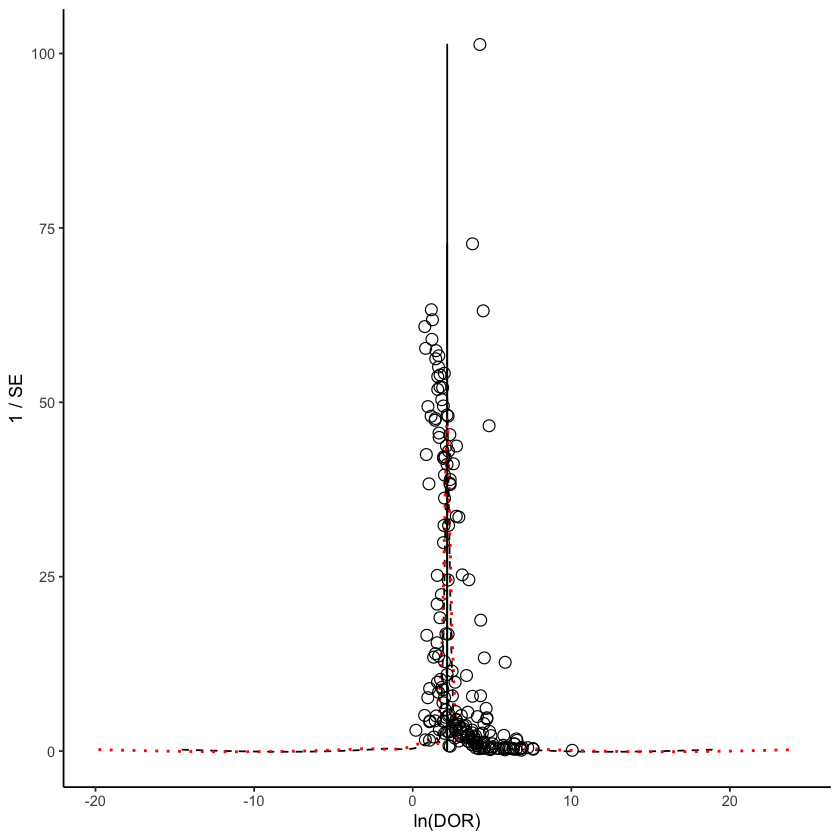

In [36]:
Funnel_plot(Data$TP, Data$FP, Data$FN, Data$TN)